In [90]:
import os
import cartopy.crs as ccrs
import sys
import glob
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import cartopy.feature as cfeature

#ouverture du fichier
file = "imerg_pr_201911_3h.nc4"
ds = xr.open_dataset(file)

#créer les variables
time = ds['time'].values
lons = ds['lon'].values
lats = ds['lat'].values
precipitation = ds["precipitationCal"].values

#emplacements (lat,lon)
points = {
    "Kuala Lumpur": (3.1, 101.6),
    "Montréal": (45.5, -73.5),
    "Point océanique": (5, 106),
    "Kathmandou": (27.7, 81.3),
}

points_montreal = {
    "Nord" : (45.9, -73.5),
    "Sud" : (45.1, -73.5),
    "Est" : (45.5, -74.1),
    "Ouest" : (45.5, -72.9),
}

points_kuala_lumpur = {
    "Nord" : (3.5, 101.6),
    "Sud" : (2.7, 101.6),
    "Est" : (3.1, 102.2),
    "Ouest" : (3.1, 101.0),
}

points_ocean = {
    "Nord" : (5.4, 106),
    "Sud" : (4.6, 106),
    "Est" : (5, 106.6),
    "Ouest" : (5, 105.4),
}

points_kathmandou = {
    "Nord" : (28.1, 81.3),
    "Sud" : (27.3, 81.3),
    "Est" : (27.7, 81.9),
    "Ouest" : (27.7, 80.7),
}

points_voisins = {
    "Montréal": points_montreal,
    "Kuala Lumpur": points_kuala_lumpur,
    "Point océanique": points_ocean,
    "Kathmandou": points_kathmandou
}


In [91]:
#valeur à chaque point
taux = {}
accumulation = {}

for nom, (lat, lon) in points.items():
    #prend le point de grille le plus près de chaque point d'intérêt
    lat_idx = np.abs(lats - lat).argmin()
    lon_idx = np.abs(lons - lon).argmin()

    #taux de precipitation
    val = precipitation[:, lat_idx, lon_idx]
    taux[nom] = val

    #accumulation
    val_accumulation = np.sum(val)
    accumulation[nom] = val_accumulation

df_taux = pd.DataFrame(taux, index=[pd.to_datetime(time)])
df_accu = pd.DataFrame([accumulation], index=["Accumulation sur le mois (mm)"])

#nombre de mesures plus grandes que 0mm
nb_mesures_positive = (df_taux > 0).sum()
df_accu.loc["Nombre de mesures > 0mm"] = nb_mesures_positive

#fréquence de précipitation
nb_total_mesure = len(df_taux)
frequence = nb_mesures_positive / nb_total_mesure
df_accu.loc["Fréquence de précipitation (%)"] = frequence * 100

#précipitation moyenne
precip_moy = df_taux.mean()
df_accu.loc["Précipitation moyenne (mm/3h)"] = precip_moy

#intensité de précipitation moyenne
precip_moy_pluie = df_taux[df_taux > 0].mean()
df_accu.loc["Intensité de précipitation moyenne (mm/3h)"] = precip_moy_pluie

#durée max d'un épisode de précipitation
def max_sequence_pluie(df_taux):
    resultats = {}
    for col in df_taux.columns:
        serie = (df_taux[col].values > 0).astype(int)
        max_run = 0
        run = 0
        for val in serie:
            if val == 1:
                run += 1
                max_run = max(max_run, run)
            else:
                run = 0
        resultats[col] = max_run
    return pd.Series(resultats, index=df_taux.columns, name="Max séquence pluie (pas 3h)")


duree_max = max_sequence_pluie(df_taux) * 3
duree_max = duree_max.reindex(df_accu.columns)
df_accu.loc["Durée max événement (h)"] = duree_max

#max taux de précipitation
maximum = df_taux.max()
df_accu.loc["Maximum du taux de précipitation (mm/3h)"] = maximum

#corrélation
correlation = {}

for nom, (lat, lon) in points.items():
    lat_idx = np.abs(lats - lat).argmin()
    lon_idx = np.abs(lons - lon).argmin()
    serie_centrale = precipitation[:, lat_idx, lon_idx]
    corr_voisins = {}
    for direction, (lat_v, lon_v) in points_voisins[nom].items():
        lat_idx_v = np.abs(lats - lat_v).argmin()
        lon_idx_v = np.abs(lons - lon_v).argmin()
        serie_voisin = precipitation[:, lat_idx_v, lon_idx_v]

        r = np.corrcoef(serie_centrale, serie_voisin)[0, 1]
        corr_voisins[direction] = r

    for direction, r in corr_voisins.items():
        df_accu.loc[f"Corrélation avec {direction}", nom] = r

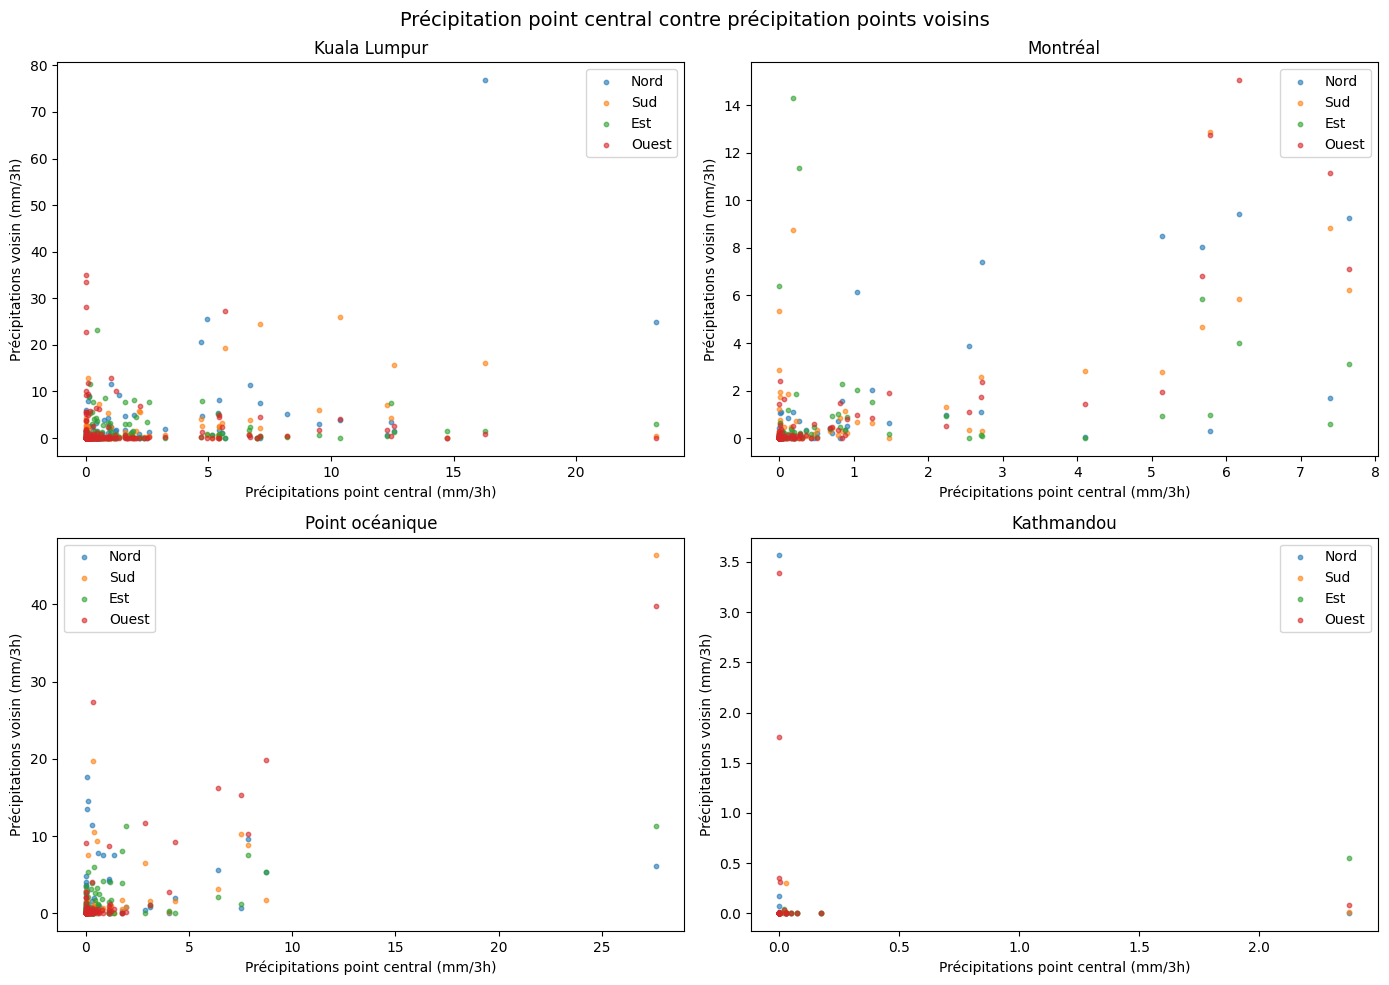

In [121]:
#nuage de points (pas sur)

# === Création des sous-figures ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (nom, (lat, lon)) in enumerate(points.items()):
    ax = axes[i]

    # Série centrale
    lat_idx = np.abs(lats - lat).argmin()
    lon_idx = np.abs(lons - lon).argmin()
    serie_centrale = precipitation[:, lat_idx, lon_idx]

    # Scatter plot : central vs voisins
    for direction, (lat_v, lon_v) in points_voisins[nom].items():
        lat_idx_v = np.abs(lats - lat_v).argmin()
        lon_idx_v = np.abs(lons - lon_v).argmin()
        serie_voisin = precipitation[:, lat_idx_v, lon_idx_v]

        # Scatter central vs voisin
        ax.scatter(serie_centrale, serie_voisin,
                   label=f"{direction}", alpha=0.6, s=10)

    ax.set_title(nom)
    ax.set_xlabel("Précipitations point central (mm/3h)")
    ax.set_ylabel("Précipitations voisin (mm/3h)")
    ax.legend()

plt.suptitle("Précipitation point central contre précipitation points voisins", fontsize=14)
plt.tight_layout()
plt.savefig("nuage_points.png", dpi=300)
plt.show()


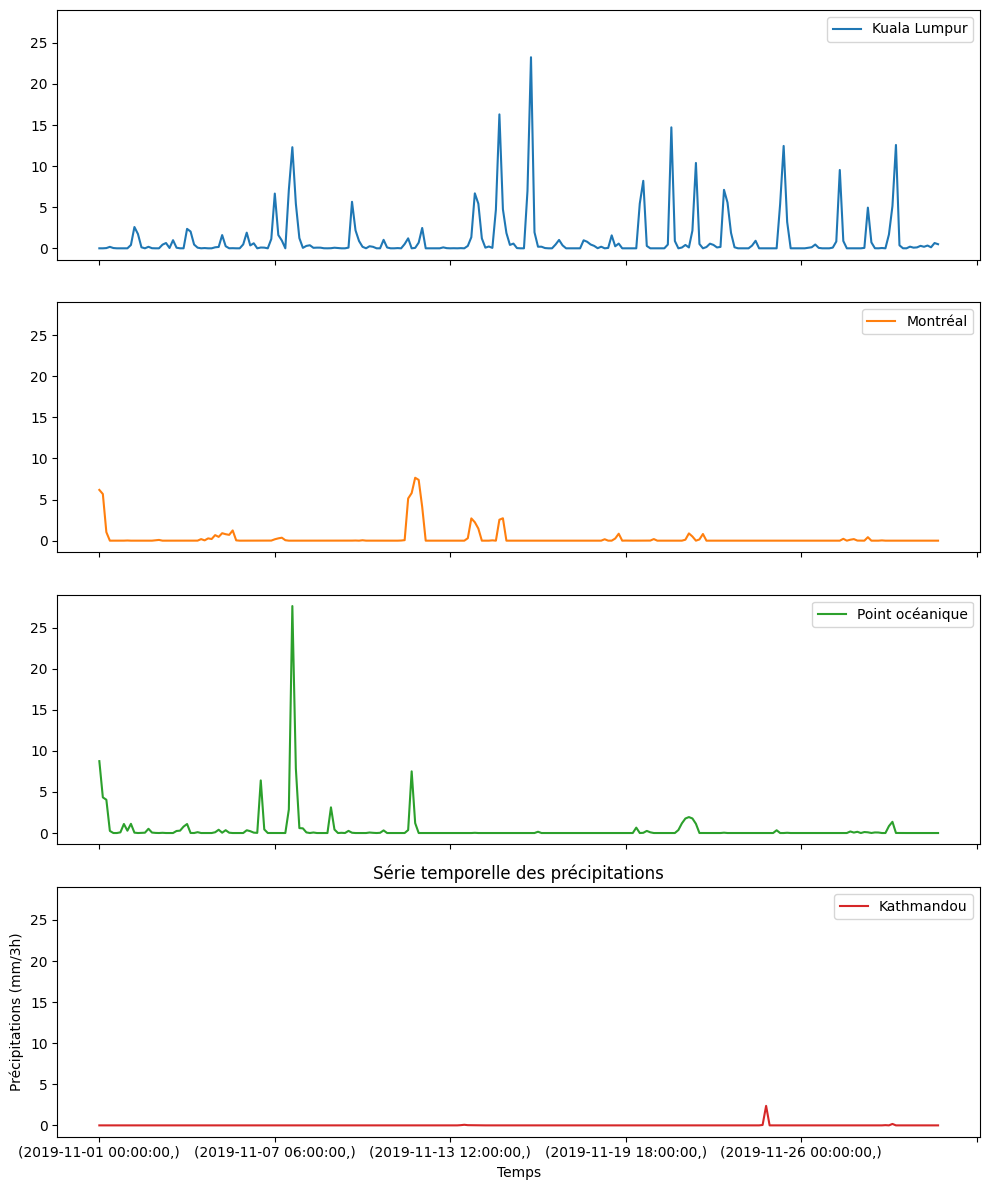

In [116]:
#création série temporelle (#2)
df_taux.plot(subplots=True,
             layout=(4, 1),
             figsize=(10, 12),
             sharex=True,
             sharey=True,
             legend=True)
plt.title("Série temporelle des précipitations")
plt.xlabel("Temps")
plt.ylabel("Précipitations (mm/3h)")

plt.tight_layout()
plt.savefig("serie_temporelle_labo3.png", dpi=300, bbox_inches="tight")

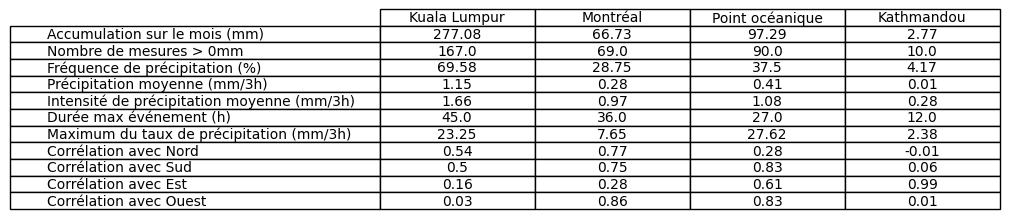

In [94]:
#création tableau (#3)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')

table = ax.table(cellText=df_accu.values.round(2),
                 colLabels=df_accu.columns,
                 rowLabels=df_accu.index,
                 cellLoc='center',
                 loc='center')

plt.savefig("tableau_accumulations_labo3.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

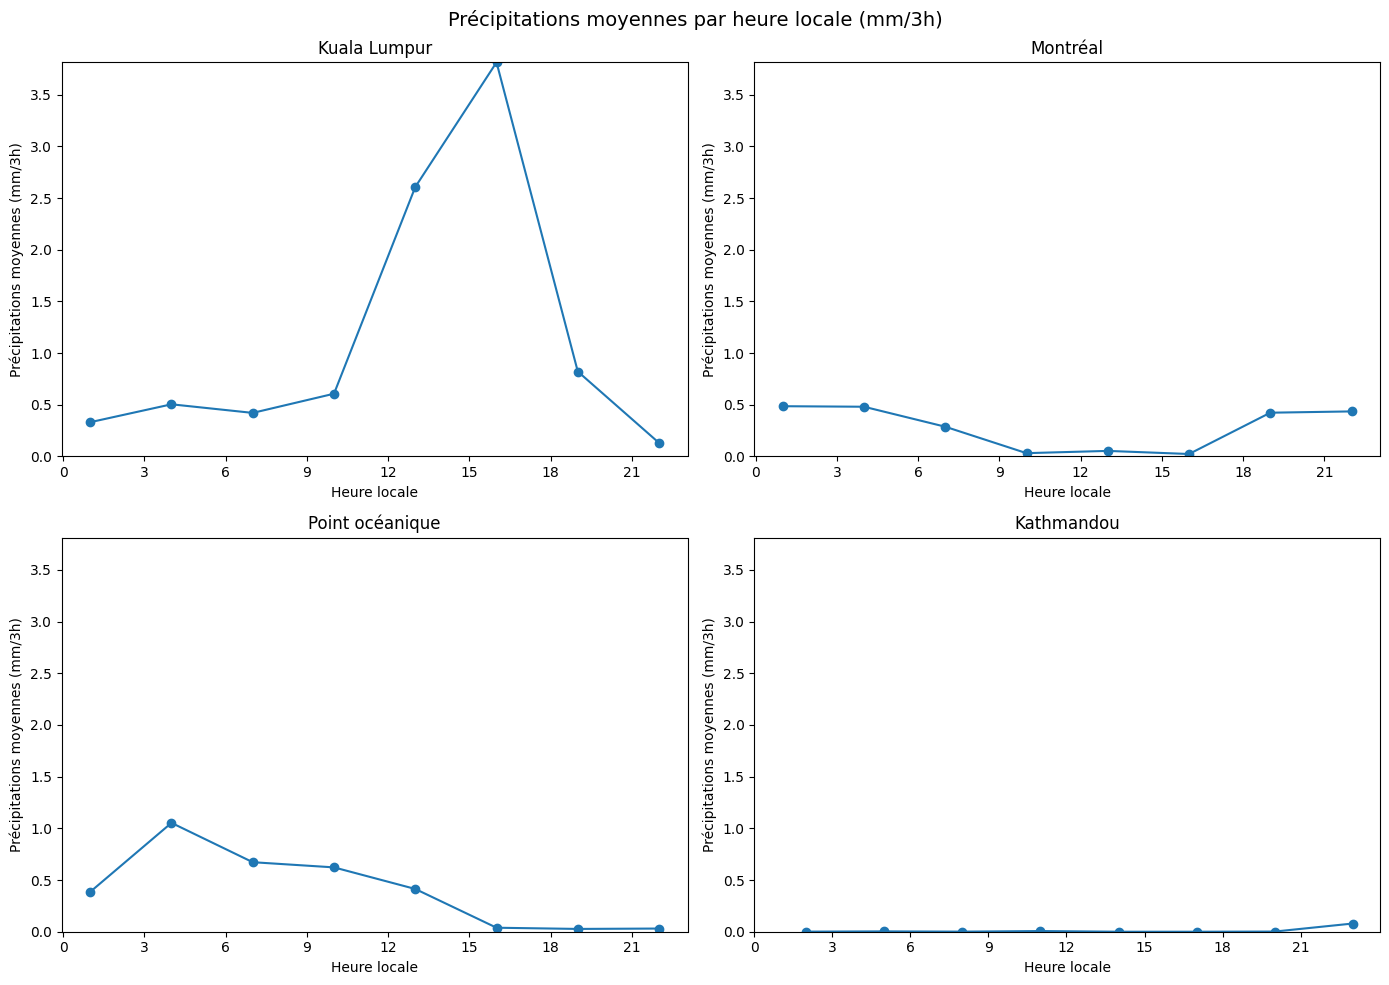

In [120]:
#cycle journalier de précipitation (#4)

# Conversion longitude, exemple Montréal (-73.5) = offset -73.5/15 = environ -5h
def lon_to_utc_offset(lon):
    return int(np.round(lon / 15))

# Création du temps en datetime64 avec UTC
time_utc = pd.to_datetime(time)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Stocker toutes les moyennes pour ajuster l'échelle Y
all_means = []

for i, (nom, (lat, lon)) in enumerate(points.items()):
    ax = axes[i]

    # Trouver l'indice du point central
    lat_idx = np.abs(lats - lat).argmin()
    lon_idx = np.abs(lons - lon).argmin()
    serie = precipitation[:, lat_idx, lon_idx]

    # Décalage horaire basé sur longitude
    offset = lon_to_utc_offset(lon)

    # Conversion en heure locale
    time_local = time_utc + pd.to_timedelta(offset, unit="h")

    # Créer un Dataset xarray pour regrouper par heure locale
    ds_point = xr.Dataset(
        {"precip": (("time"), serie)},
        coords={"time": time_local}
    )

    # Moyenne par heure de la journée
    mean_hourly = ds_point["precip"].groupby("time.hour").mean()

    # Sauvegarde des moyennes pour normaliser l’axe Y
    all_means.append(mean_hourly.values)

    # Tracer
    ax.plot(mean_hourly["hour"], mean_hourly.values, marker="o")
    ax.set_title(nom)
    ax.set_xlabel("Heure locale")
    ax.set_ylabel("Précipitations moyennes (mm/3h)")
    ax.set_xticks(range(0, 24, 3))

# Fixer la même échelle pour tous
ymin = 0
ymax = max([vals.max() for vals in all_means])
for ax in axes:
    ax.set_ylim(ymin, ymax)

plt.suptitle("Précipitations moyennes par heure locale (mm/3h)", fontsize=14)
plt.tight_layout()
plt.savefig("precip_par_heure.png", dpi=300)
plt.show()

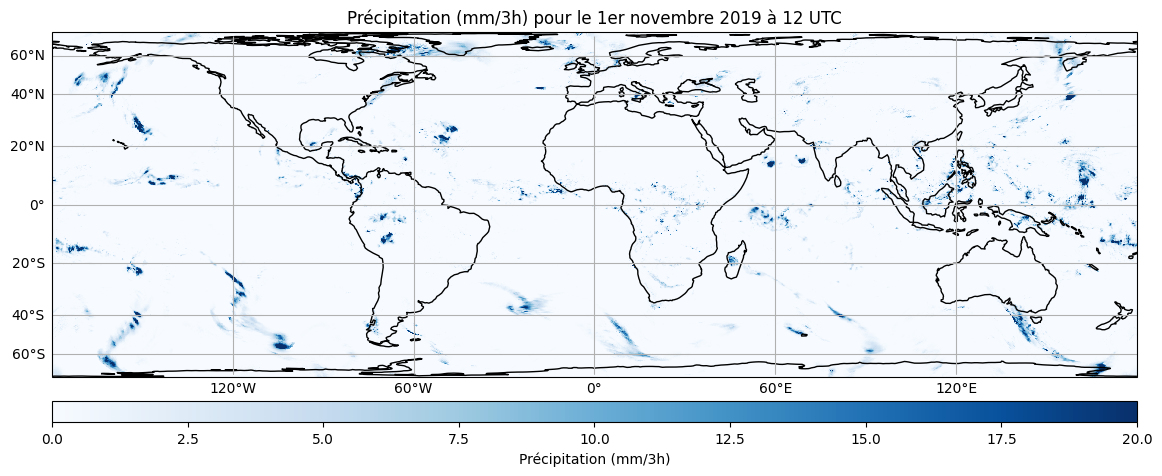

In [147]:
#carte
date_cible = "2019-11-01T12:00"
ds_cible = ds.sel(time=pd.to_datetime(date_cible))

pr_1novembre = ds_cible["precipitationCal"].values

#figure
fig = plt.figure(figsize=(14, 6))
proj = ccrs.LambertCylindrical()
ax = plt.axes(projection=proj)

#Carte
pcm = ax.pcolormesh(
    lons, lats, pr_1novembre,
    transform=ccrs.LambertCylindrical(),
    cmap="Blues",
    vmin=0, vmax=20
)

ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='black', alpha = 0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

#ax.set_xticks(range(-180, 181, 60), crs=ccrs.LambertCylindrical())
#ax.set_yticks(range(-90, 91, 30), crs=ccrs.LambertCylindrical())
#ax.gridlines(draw_labels=False)

plt.title("Précipitation (mm/3h) pour le 1er novembre 2019 à 12 UTC")
cbar = plt.colorbar(pcm, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("Précipitation (mm/3h)")

plt.savefig("carte_1er_nov.png", dpi=300)
plt.show()

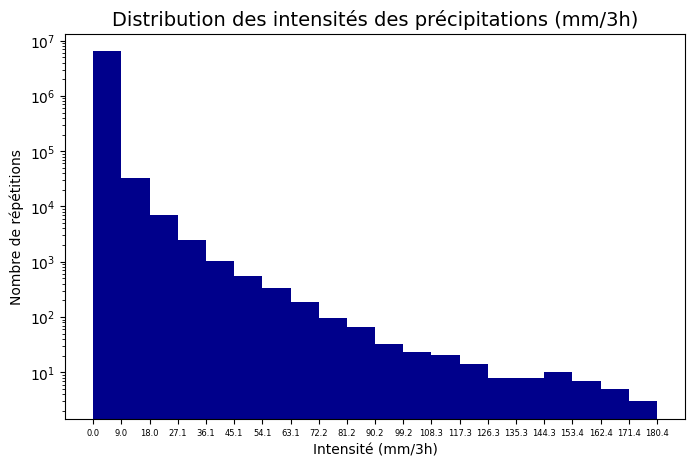

In [114]:
#histogramme (#2)
pr_1D = np.ravel(pr_1novembre)

plt.figure(figsize=(8, 5))
plt.hist(pr_1D, bins=20, range=(0, np.max(pr_1D)), color = "darkblue", histtype="stepfilled")

plt.yscale("log")
plt.title("Distribution des intensités des précipitations (mm/3h)", fontsize=14)
plt.xlabel("Intensité (mm/3h)")
plt.xticks(np.linspace(0, np.max(pr_1novembre), 21), fontsize=6)
plt.ylabel("Nombre de répétitions")
plt.savefig("histogramme.png", dpi=300, bbox_inches="tight")

plt.show()

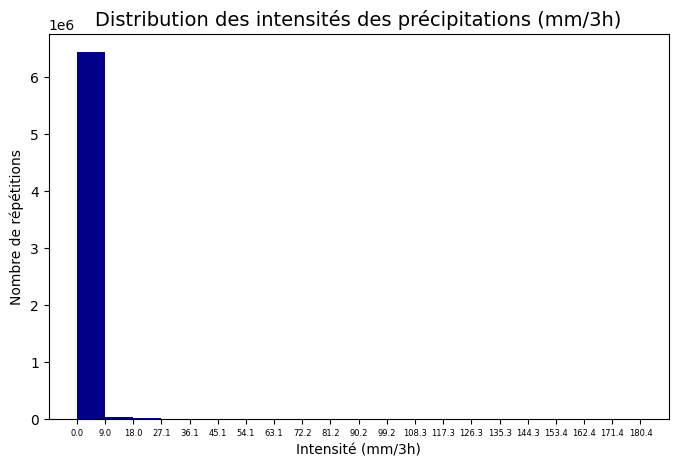

In [115]:
#histogramme sans log(#2)
pr_1D = np.ravel(pr_1novembre)

plt.figure(figsize=(8, 5))
plt.hist(pr_1D, bins=20, range=(0, np.max(pr_1D)), color = "darkblue", histtype="stepfilled")

plt.title("Distribution des intensités des précipitations (mm/3h)", fontsize=14)
plt.xlabel("Intensité (mm/3h)")
plt.xticks(np.linspace(0, np.max(pr_1novembre), 21), fontsize=6)
plt.ylabel("Nombre de répétitions")
plt.savefig("histogramme_sans_log.png", dpi=300, bbox_inches="tight")

plt.show()

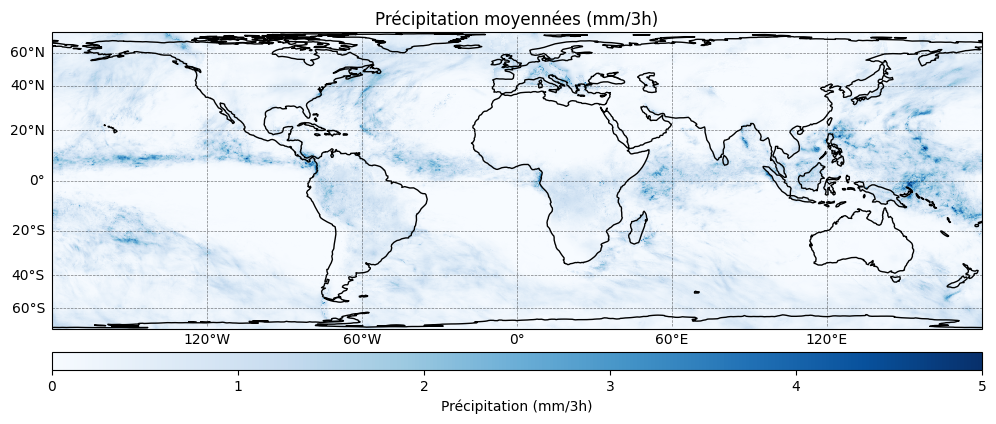

In [149]:
#distribution spatiale moyennée
#figure
fig = plt.figure(figsize=(12, 6))
proj = ccrs.LambertCylindrical()
ax = plt.axes(projection=proj)

precipitation_moyennee = np.mean(precipitation, axis=0)

#Carte
pcm = ax.pcolormesh(
    lons, lats, precipitation_moyennee,
    transform=ccrs.LambertCylindrical(),
    cmap="Blues",
    vmin=0, vmax=5
)

ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='black', alpha = 0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

#ax.set_xticks(range(-180, 181, 30), crs=ccrs.LambertCylindrical())
#ax.set_yticks(range(-90, 91, 30), crs=ccrs.LambertCylindrical())
#ax.gridlines(draw_labels=False)

plt.title("Précipitation moyennées (mm/3h)")
cbar = plt.colorbar(pcm, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("Précipitation (mm/3h)")

plt.savefig("carte_moyenne.png", dpi=300, bbox_inches="tight")
plt.show()

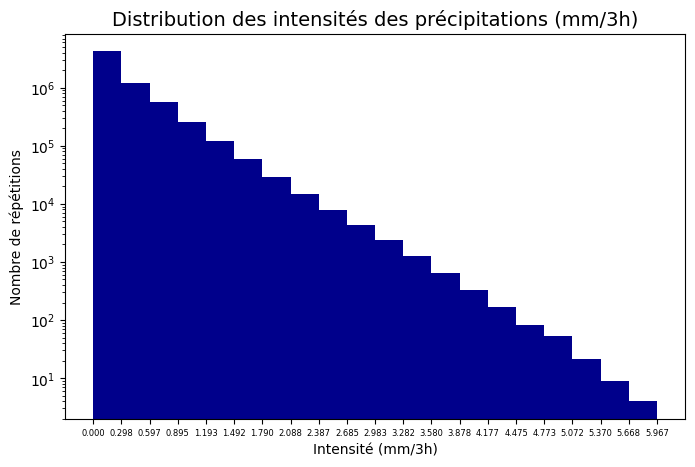

In [99]:
#histogramme (#2)
pr_moy_1D = np.ravel(precipitation_moyennee)

plt.figure(figsize=(8, 5))
plt.hist(pr_moy_1D, bins=20, range=(0, np.max(precipitation_moyennee)), color = "darkblue", histtype="stepfilled")

plt.yscale("log")
plt.title("Distribution des intensités des précipitations (mm/3h)", fontsize=14)
plt.xlabel("Intensité (mm/3h)")
plt.xticks(np.linspace(0, np.max(precipitation_moyennee), 21), fontsize=6)
plt.ylabel("Nombre de répétitions")
plt.savefig("histogramme_moyenné.png", dpi=300, bbox_inches="tight")

plt.show()


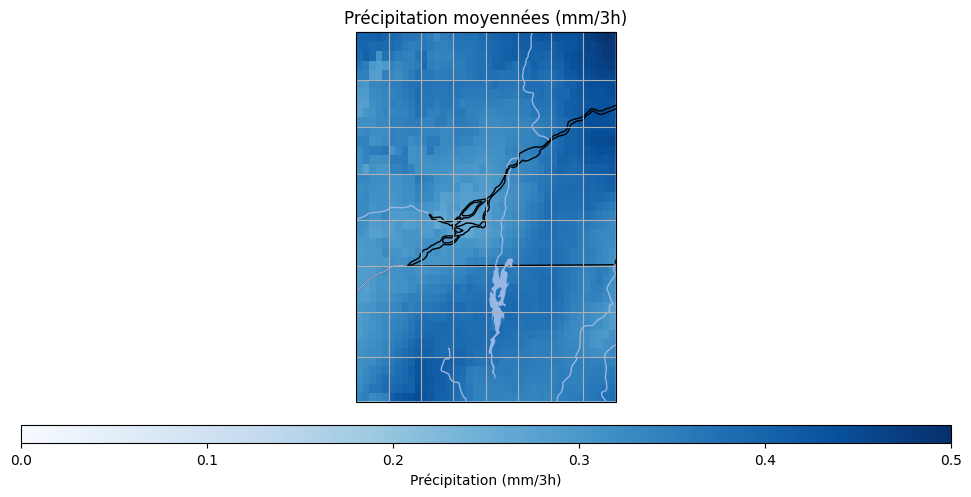

In [137]:
#distribution spatiale montréal
#figure

lat_mtl, lon_mtl = 45.5, -73.5

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Mercator())

#Carte
pcm = ax.pcolormesh(
    lons, lats, precipitation_moyennee,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    vmin=0, vmax=0.5
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks(range(-180, 181, 60), crs=ccrs.Mercator())
ax.set_yticks(range(-90, 91, 30), crs=ccrs.Mercator())

ax.gridlines(draw_labels=False)

ax.set_extent([lon_mtl - 2, lon_mtl + 2, lat_mtl - 2, lat_mtl + 2], crs=ccrs.PlateCarree())

plt.title("Précipitation moyennées (mm/3h)")
cbar = plt.colorbar(pcm, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("Précipitation (mm/3h)")

plt.savefig("carte_moyenne_mtl_pcolomesh.png", dpi=300, bbox_inches="tight")
plt.show()

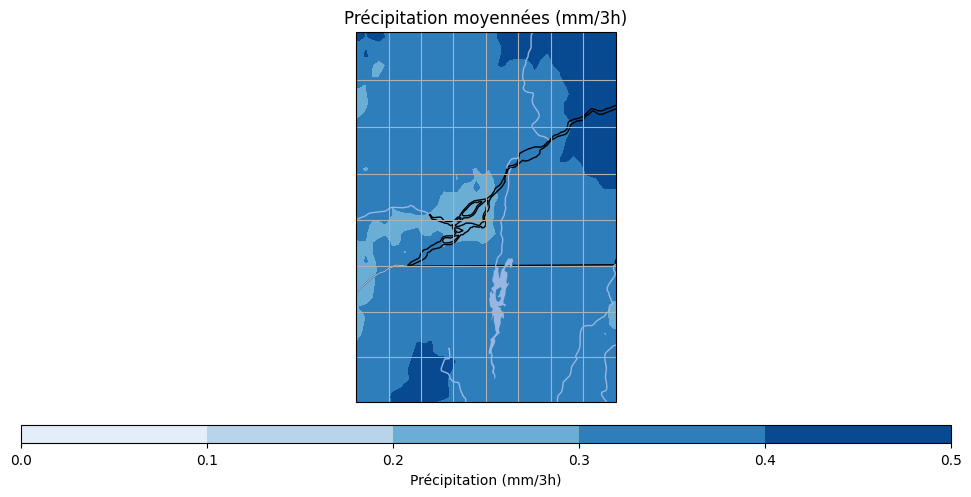

In [136]:
#distribution spatiale montréal
#figure

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Mercator())

levels = np.linspace(0, 0.5, 6)

#Carte
pcm = ax.contourf(
    lons, lats, precipitation_moyennee,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    levels=levels,

)

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks(range(-180, 181, 180), crs=ccrs.Mercator())
ax.set_yticks(range(-90, 91, 90), crs=ccrs.Mercator())

ax.gridlines(draw_labels=False)

ax.set_extent([lon_mtl - 2, lon_mtl + 2, lat_mtl - 2, lat_mtl + 2], crs=ccrs.PlateCarree())

plt.title("Précipitation moyennées (mm/3h)")
cbar = plt.colorbar(pcm, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("Précipitation (mm/3h)")

plt.savefig("carte_moyenne_mtl_contourf.png", dpi=300, bbox_inches="tight")
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


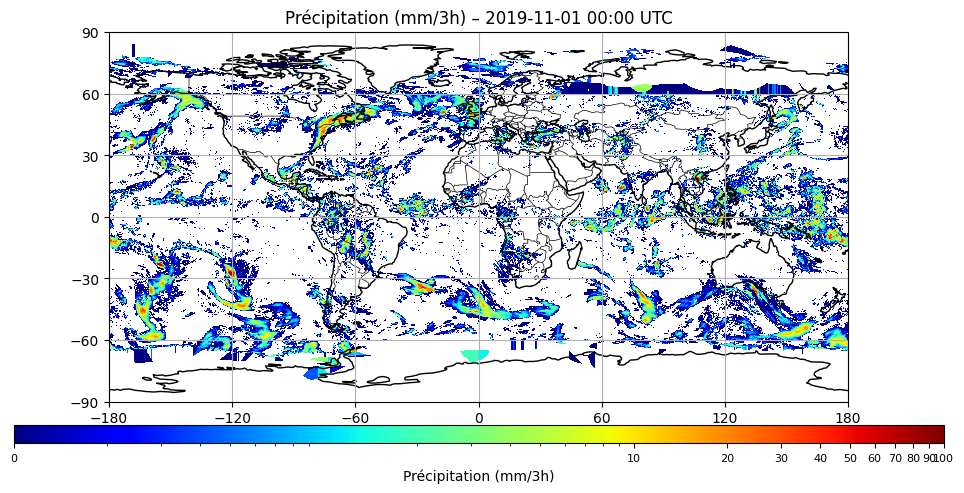

In [141]:
from matplotlib import animation
import matplotlib.colors as mcolors

#animation (bonus)
times = pd.to_datetime(ds["time"].values)
nt = precipitation.shape[0]

# === Figure et carte ===
fig = plt.figure(figsize=(12, 6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)

pcm = ax.pcolormesh(
    lons, lats, precipitation[0, :, :],
    transform=ccrs.PlateCarree(),
    cmap="jet",
    norm = mcolors.LogNorm(vmin=0.1, vmax=100)
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_xticks(range(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=False)


cbar = plt.colorbar(pcm, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("Précipitation (mm/3h)")

ticks = np.linspace(0, 100, 10)
cbar.set_ticks([0.1, 10, 20, 30,40,50,60,70,80,90,100])
cbar.set_ticklabels(["0", "10", "20", "30", "40", "50", "60", "70", "80", "90", "100"], fontsize=8)

# === Fonction de mise à jour ===
def update(frame):
    pcm.set_array(precipitation[frame, :, :].ravel())
    ax.set_title(f"Précipitation (mm/3h) – {times[frame].strftime('%Y-%m-%d %H:%M UTC')}")
    return [pcm]

# === Animation ===
ani = animation.FuncAnimation(fig, update, frames=nt, interval=150, blit=False)

# Sauvegarde
ani.save("precipitation_animation_labo3.gif", writer="imagemagick", dpi=300)

